In [ ]:
import keras
from keras import layers
from PIL import Image
from IPython.core.display import Path
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization")


100%|██████████| 192M/192M [00:01<00:00, 192MB/s]


In [ ]:
def load_data(path_X, path_Y):
    X = list()

    Y = list()
    # iterate over files in
    # that directory
    files = Path(path_X).glob('*')
    # print('------------------train images---------------')
    for i,file in enumerate(files):
        # if(i==num_train):
        #   break
        im = Image.open(file)
        im = im.resize(size=(128,128))
        na = np.array(im)
        X.append(na)

    # print("===================test images=====================")
    files = Path(path_Y).glob('*')
    for i,file in enumerate(files):
        im = Image.open(file)
        im = im.resize(size=(128,128))
        na = np.array(im)
        if len(na.shape) == 3:
          if na.shape[2] == 3:
             Y.append(na)

    return np.array(X), np.array(Y)
X, Y=load_data('/content/landscape-image-colorization/landscape Images/gray','/content/landscape-image-colorization/landscape Images/color')

In [ ]:
X = X.astype('float32') / 255
Y = Y.astype('float32') / 255

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.05, random_state=45)

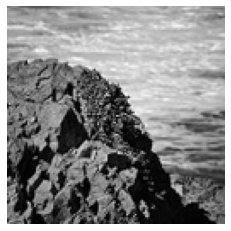

In [ ]:
plt.axis("off")
plt.imshow((x_train[0]), cmap='gray')
plt.show()

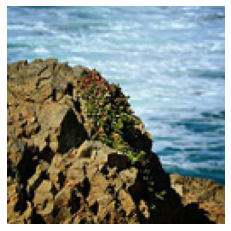

In [ ]:
plt.axis("off")
plt.imshow((y_train[0]))
plt.show()

##**U Net Arc.**

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,1))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 32)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 64)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 128)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 256)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 256)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 128)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 64)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 32)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss="mse")

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = unet_model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
212/212 [==============================] - 40s 184ms/step - loss: 0.0177 - val_loss: 0.0075
Epoch 2/15
212/212 [==============================] - 38s 181ms/step - loss: 0.0078 - val_loss: 0.0064
Epoch 3/15
212/212 [==============================] - 38s 178ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 4/15
212/212 [==============================] - 38s 179ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 5/15
212/212 [==============================] - 38s 178ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 6/15
212/212 [==============================] - 38s 178ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 7/15
212/212 [==============================] - 38s 178ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/15
212/212 [==============================] - 38s 178ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 9/15
212/212 [==============================] - 38s 178ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 10/15
212/212 [==============================] - 38s 178ms/step - l

In [ ]:
colored_imgs = unet_model.predict(x_test)

12/12 [==============================] - 1s 60ms/step


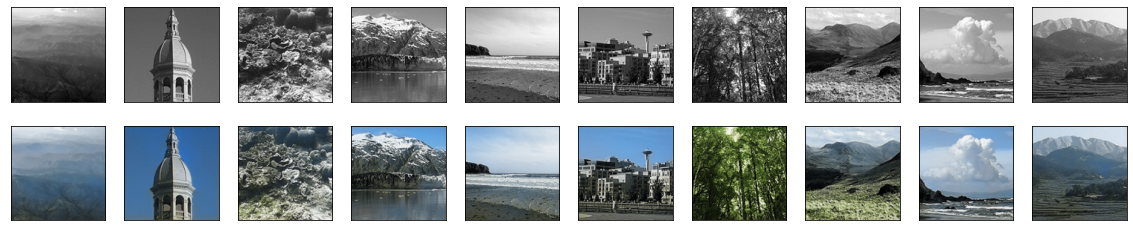

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.clip(colored_imgs[i], 0., 1.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,1))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss="mse")

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_58[0][0]']              
                                )                                                             

In [ ]:
history = unet_model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
212/212 [==============================] - 112s 485ms/step - loss: 0.0215 - val_loss: 0.0075
Epoch 2/15
212/212 [==============================] - 95s 450ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 3/15
212/212 [==============================] - 96s 451ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 4/15
212/212 [==============================] - 96s 451ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 5/15
212/212 [==============================] - 96s 451ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 6/15
212/212 [==============================] - 96s 451ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 7/15
212/212 [==============================] - 96s 452ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 8/15
212/212 [==============================] - 96s 451ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 9/15
212/212 [==============================] - 96s 451ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 10/15
212/212 [==============================] - 96s 455ms/step - 

In [ ]:
colored_imgs = unet_model.predict(x_test)

12/12 [==============================] - 2s 141ms/step


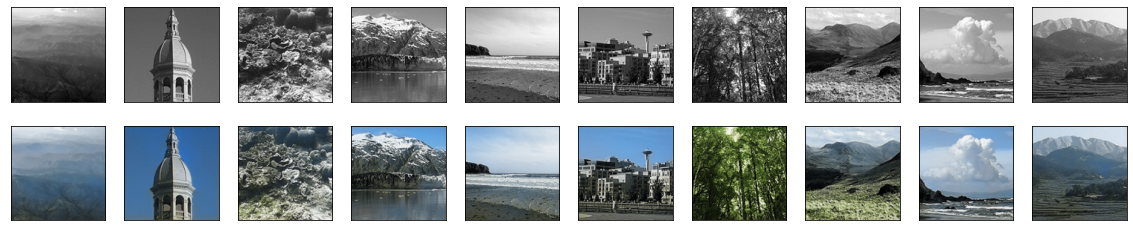

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.clip(colored_imgs[i], 0., 1.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,1))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 8)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 16)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 32)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 64)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 128)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 64)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 32)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 16)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 8)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss="mse")

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 8)  80          ['input_2[0][0]']                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 8)  584         ['conv2d_19[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 8)   0           ['conv2d_20[0][0]']          

In [ ]:
history = unet_model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
212/212 [==============================] - 21s 55ms/step - loss: 0.0428 - val_loss: 0.0135
Epoch 2/15
212/212 [==============================] - 10s 48ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 3/15
212/212 [==============================] - 11s 51ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 4/15
212/212 [==============================] - 11s 49ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 5/15
212/212 [==============================] - 10s 49ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/15
212/212 [==============================] - 10s 49ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/15
212/212 [==============================] - 10s 49ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 8/15
212/212 [==============================] - 10s 49ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 9/15
212/212 [==============================] - 10s 49ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 10/15
212/212 [==============================] - 10s 49ms/step - loss: 0.006

In [ ]:
colored_imgs = unet_model.predict(x_test)

12/12 [==============================] - 0s 17ms/step


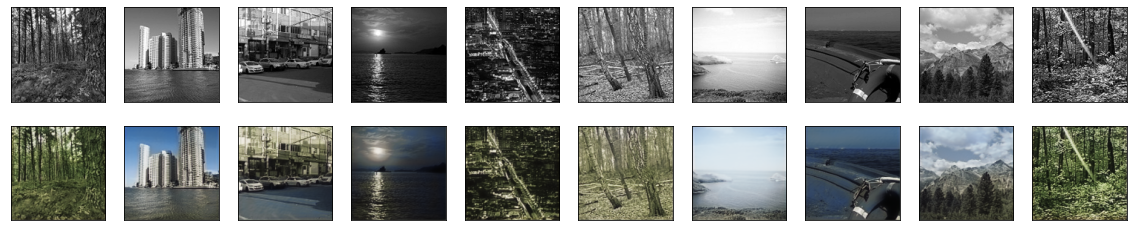

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.clip(colored_imgs[i], 0., 1.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()